In [1]:
import os
import sys
import ast
import json
from collections import defaultdict

import cv2
import numpy as np
import pandas as pd
import neuroglancer
from tqdm import tqdm
from skimage import io
import imagesize

sys.path.append(os.path.join(os.getcwd(), '../'))
from utilities.file_location import FileLocationManager
from utilities.sqlcontroller import SqlController
from utils import get_structure_number

Connecting dklab@db.dk.ucsd.edu:3306


In [2]:
animal = 'MD589'
downsample_factor = 16
all_structures = False

# OUTPUT_DIR_PATH = os.path.join(os.path.expanduser('~'))
OUTPUT_DIR_PATH = os.path.join('./')
CSV_DIR_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/foundation_brain_annotations'
IMAGE_DIR_PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH1/full'
    
sqlController = SqlController(animal)
resolution = sqlController.scan_run.resolution
aligned_shape = np.array((sqlController.scan_run.width, sqlController.scan_run.height))
num_section = len(os.listdir(IMAGE_DIR_PATH))

downsampled_aligned_shape = np.round(aligned_shape / downsample_factor).astype(int)
scales = np.array([resolution * downsample_factor, resolution * downsample_factor, 20]) * 1000

db_structures = sqlController.get_structures_dict()

## Get the annotation points

In [3]:
def get_dense_coordinates(coor_list):
    dense_coor_list = []
    # Shortest distance, x, y

    # for x, y in coor_list:
    for i in range(len(coor_list) - 1):
        x, y = coor_list[i]
        x_next, y_next = coor_list[i + 1]

        x_mid = (x + x_next) / 2
        y_mid = (y + y_next) / 2

        dense_coor_list.append([x, y])
        dense_coor_list.append([x_mid, y_mid])

        if i == len(coor_list) - 2:
            dense_coor_list.append([x_next, y_next])
            x, y = coor_list[0]
            x_mid = (x + x_next) / 2
            y_mid = (y + y_next) / 2
            dense_coor_list.append([x_mid, y_mid])

    return dense_coor_list

def get_contours_from_annotations(stack, target_structure, hand_annotations, densify=0):
    MD585_ng_section_min = 83
    num_annotations = len(hand_annotations)
    str_contours_annotation = {}

    for i in range(num_annotations):
        structure = hand_annotations['name'][i]
        side = hand_annotations['side'][i]
        section = hand_annotations['section'][i]
        first_sec = 0
        last_sec = 0

        #if side == 'R' or side == 'L':
        #    structure = structure + '_' + side

        if structure == target_structure:
            vertices = hand_annotations['vertices'][i]

            for i in range(densify):
                vertices = get_dense_coordinates(vertices)

            # Skip sections before the 22nd prep2 section for MD585 as there are clear errors
            if stack == 'MD585' and section < MD585_ng_section_min + 22:
                # vertices = vertices - np.array(MD585_abberation_correction)
                continue
            str_contours_annotation[section] = {}
            str_contours_annotation[section][structure] = {}
            str_contours_annotation[section][structure][1] = vertices

    try:
        first_sec = np.min(list(str_contours_annotation.keys()))
        last_sec = np.max(list(str_contours_annotation.keys()))
    except:
        pass
    return str_contours_annotation, first_sec, last_sec

csvfile = os.path.join(CSV_DIR_PATH, f'{animal}_annotation.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations['vertices'] = hand_annotations['vertices'] \
    .apply(lambda x: x.replace(' ', ','))\
    .apply(lambda x: x.replace('\n',','))\
    .apply(lambda x: x.replace(',]',']'))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ',')).apply(lambda x: x.replace(',,', ','))
hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))
csv_structures = hand_annotations['name'].unique()

selected_structures = csv_structures if all_structures else db_structures
section_structure_vertices = defaultdict(dict)
for structure in tqdm(selected_structures):
    contour_annotations, first_sec, last_sec = get_contours_from_annotations(animal, structure, hand_annotations, densify=0)
    for section in contour_annotations:
        section_structure_vertices[section][structure] = contour_annotations[section][structure][1]

100%|██████████| 28/28 [00:01<00:00, 18.23it/s]


## Reproduce create_clean transform

In [4]:
section_offset = {}
for file_name in tqdm(sorted(os.listdir(IMAGE_DIR_PATH))):
    filepath = os.path.join(IMAGE_DIR_PATH, file_name)
    
    # Use imread is too slow for full res images
    width, height = imagesize.get(filepath)
    downsampled_shape = np.round(np.array((width, height)) / downsample_factor)
    
    section = int(file_name.split('.')[0])
    section_offset[section] = (downsampled_aligned_shape - downsampled_shape) // 2

100%|██████████| 447/447 [00:00<00:00, 768.12it/s]


## Reproduce create_alignment transform

In [5]:
def parse_elastix_parameter_file(filepath, tf_type=None):
    """
    Parse elastix parameter result file.
    """
    def parameter_elastix_parameter_file_to_dict(filename):
        d = {}
        with open(filename, 'r') as f:
            for line in f.readlines():
                if line.startswith('('):
                    tokens = line[1:-2].split(' ')
                    key = tokens[0]
                    if len(tokens) > 2:
                        value = []
                        for v in tokens[1:]:
                            try:
                                value.append(float(v))
                            except ValueError:
                                value.append(v)
                    else:
                        v = tokens[1]
                        try:
                            value = (float(v))
                        except ValueError:
                            value = v
                    d[key] = value
            return d

    d = parameter_elastix_parameter_file_to_dict(filepath)

    if tf_type is None:
        # For alignment composition script
        rot_rad, x_mm, y_mm = d['TransformParameters']
        center = np.array(d['CenterOfRotationPoint']) / np.array(d['Spacing'])
        # center[1] = d['Size'][1] - center[1]

        xshift = x_mm / d['Spacing'][0]
        yshift = y_mm / d['Spacing'][1]

        R = np.array([[np.cos(rot_rad), -np.sin(rot_rad)],
                      [np.sin(rot_rad), np.cos(rot_rad)]])
        shift = center + (xshift, yshift) - np.dot(R, center)
        T = np.vstack([np.column_stack([R, shift]), [0, 0, 1]])
        return T

    elif tf_type == 'rigid3d':
        p = np.array(d['TransformParameters'])
        center = np.array(d['CenterOfRotationPoint']) / np.array(d['Spacing'])
        shift = p[3:] / np.array(d['Spacing'])

        thetax, thetay, thetaz = p[:3]
        # Important to use the negative angle.
        cx = np.cos(-thetax)
        cy = np.cos(-thetay)
        cz = np.cos(-thetaz)
        sx = np.sin(-thetax)
        sy = np.sin(-thetay)
        sz = np.sin(-thetaz)
        Rx = np.array([[1, 0, 0], [0, cx, sx], [0, -sx, cx]])
        Ry = np.array([[cy, 0, sy], [0, 1, 0], [-sy, 0, cy]])
        Rz = np.array([[cz, sz, 0], [-sz, cz, 0], [0, 0, 1]])

        R = np.dot(np.dot(Rz, Ry), Rx)
        # R = np.dot(np.dot(Rx, Ry), Rz)
        # The order could be Rx,Ry,Rz - not sure.

        return R, shift, center

    elif tf_type == 'affine3d':
        p = np.array(d['TransformParameters'])
        L = p[:9].reshape((3, 3))
        shift = p[9:] / np.array(d['Spacing'])
        center = np.array(d['CenterOfRotationPoint']) / np.array(d['Spacing'])
        # shift = center + shift - np.dot(L, center)
        # T = np.column_stack([L, shift])
        return L, shift, center

    elif tf_type == 'bspline3d':
        n_params = d['NumberOfParameters']
        p = np.array(d['TransformParameters'])
        grid_size = d['GridSize']
        grid_spacing = d['GridSpacing']
        grid_origin = d['GridOrigin']

        return L, shift, center

def load_consecutive_section_transform(stack, moving_fn, fixed_fn):
    """
    Load pairwise transform.

    Returns:
        (3,3)-array.
    """
    assert stack is not None
    fileLocationManager = FileLocationManager(stack)
    elastix_output_dir = fileLocationManager.elastix_dir
    param_fp = os.path.join(elastix_output_dir, moving_fn + '_to_' + fixed_fn, 'TransformParameters.0.txt')
    #sys.stderr.write('Load elastix-computed transform: %s\n' % param_fp)
    if not os.path.exists(param_fp):
        raise Exception('Transform file does not exist: %s to %s, %s' % (moving_fn, fixed_fn, param_fp))
    transformation_to_previous_sec = parse_elastix_parameter_file(param_fp)

    return transformation_to_previous_sec

def parse_elastix(animal):
    """
    After the elastix job is done, this goes into each subdirectory and parses the Transformation.0.txt file
    Args:
        animal: the animal
    Returns: a dictionary of key=filename, value = coordinates
    """
    fileLocationManager = FileLocationManager(animal)
    DIR = fileLocationManager.prep
    INPUT = os.path.join(DIR, 'CH1', 'thumbnail_cleaned')

    image_name_list = sorted(os.listdir(INPUT))
    anchor_idx = len(image_name_list) // 2
    # anchor_idx = len(image_name_list) - 1
    transformation_to_previous_sec = {}

    for i in range(1, len(image_name_list)):
        fixed_fn = os.path.splitext(image_name_list[i - 1])[0]
        moving_fn = os.path.splitext(image_name_list[i])[0]
        transformation_to_previous_sec[i] = load_consecutive_section_transform(animal, moving_fn, fixed_fn)

    transformation_to_anchor_sec = {}
    # Converts every transformation
    for moving_idx in range(len(image_name_list)):
        if moving_idx == anchor_idx:
            transformation_to_anchor_sec[image_name_list[moving_idx]] = np.eye(3)
        elif moving_idx < anchor_idx:
            T_composed = np.eye(3)
            for i in range(anchor_idx, moving_idx, -1):
                T_composed = np.dot(np.linalg.inv(transformation_to_previous_sec[i]), T_composed)
            transformation_to_anchor_sec[image_name_list[moving_idx]] = T_composed
        else:
            T_composed = np.eye(3)
            for i in range(anchor_idx + 1, moving_idx + 1):
                T_composed = np.dot(transformation_to_previous_sec[i], T_composed)
            transformation_to_anchor_sec[image_name_list[moving_idx]] = T_composed

    return transformation_to_anchor_sec

def create_warp_transforms(transforms, downsample_factor=32):
    def convert_2d_transform_forms(arr):
        return np.vstack([arr, [0, 0, 1]])
    
    transforms_scale_factor = 32 / downsample_factor 
    tf_mat_mult_factor = np.array([[1, 1, transforms_scale_factor], [1, 1, transforms_scale_factor]])
    transforms_to_anchor = {}
    for img_name, tf in transforms.items():
        transforms_to_anchor[img_name] = convert_2d_transform_forms(np.reshape(tf, (3, 3))[:2] * tf_mat_mult_factor) 

    return transforms_to_anchor

transforms = parse_elastix(animal)
warp_transforms = create_warp_transforms(transforms, downsample_factor)
ordered_transforms = sorted(warp_transforms.items())

section_transform = {}
for section, transform in ordered_transforms:
    section_num = int(section.split('.')[0])
    transform = np.linalg.inv(transform)
    section_transform[section_num] = transform

## Alignment of annotation coordinates

In [6]:
def transform_create_alignment(points, transform):
    '''
    (x, y) = points[i]
    T = transform
    
    (x', y') = (x * sx + y * ry + tx, x * rx + y * sy + ty)
    'sx': T[0, 0], 'sy': T[1, 1], 'rx': T[1, 0], 'ry': T[0, 1], 'tx': T[0, 2], 'ty': T[1, 2]
    '''
    a = np.hstack((points, np.ones((points.shape[0], 1))))
    b = transform.T[:, 0:2]
    c = np.matmul(a, b)
    return c

aligned_section_structure_polygons = defaultdict(dict)
for section in section_structure_vertices:
    for structure in section_structure_vertices[section]:
        points = np.array(section_structure_vertices[section][structure]) // downsample_factor
        points = points + section_offset[section] # create_clean offset
        points = transform_create_alignment(points, section_transform[section]) # create_alignment transform
        aligned_section_structure_polygons[section][structure] = [points]

In [83]:
import pickle

vertices_path = os.path.join(OUTPUT_DIR_PATH, f'{animal}_aligned_section_structure_polygons_down{downsample_factor}.pickle')
with open(vertices_path, 'wb') as file:
    pickle.dump(aligned_section_structure_polygons, file)

## Reverse process

http://vr.cs.uiuc.edu/node81.html#eqn:homog

In [7]:
def reverse_transform_create_alignment(points, transform):
    c = np.hstack((points, np.ones((points.shape[0], 1))))
    b = transform.copy()[:, 0:2] # Reverse rotation matrix by doing R^-1 = R^T
    b[2:, 0:2] = -transform[0:2, 2] # Reverse translation matrix by doing -T
    a = np.matmul(c, b)
    return a

section_structure_polygons = defaultdict(dict)
for section in aligned_section_structure_polygons:
    for structure in aligned_section_structure_polygons[section]:
        points = aligned_section_structure_polygons[section][structure][0]
        points = reverse_transform_create_alignment(points, section_transform[section]) # reverse create_alignment transform
        points = points - section_offset[section] # reverse create_clean offset

        section_structure_polygons[section][structure] = [points]

To this point, section_structure_polygons variable contains the reversed polygon vertices from their aligned version for each structure in each section.

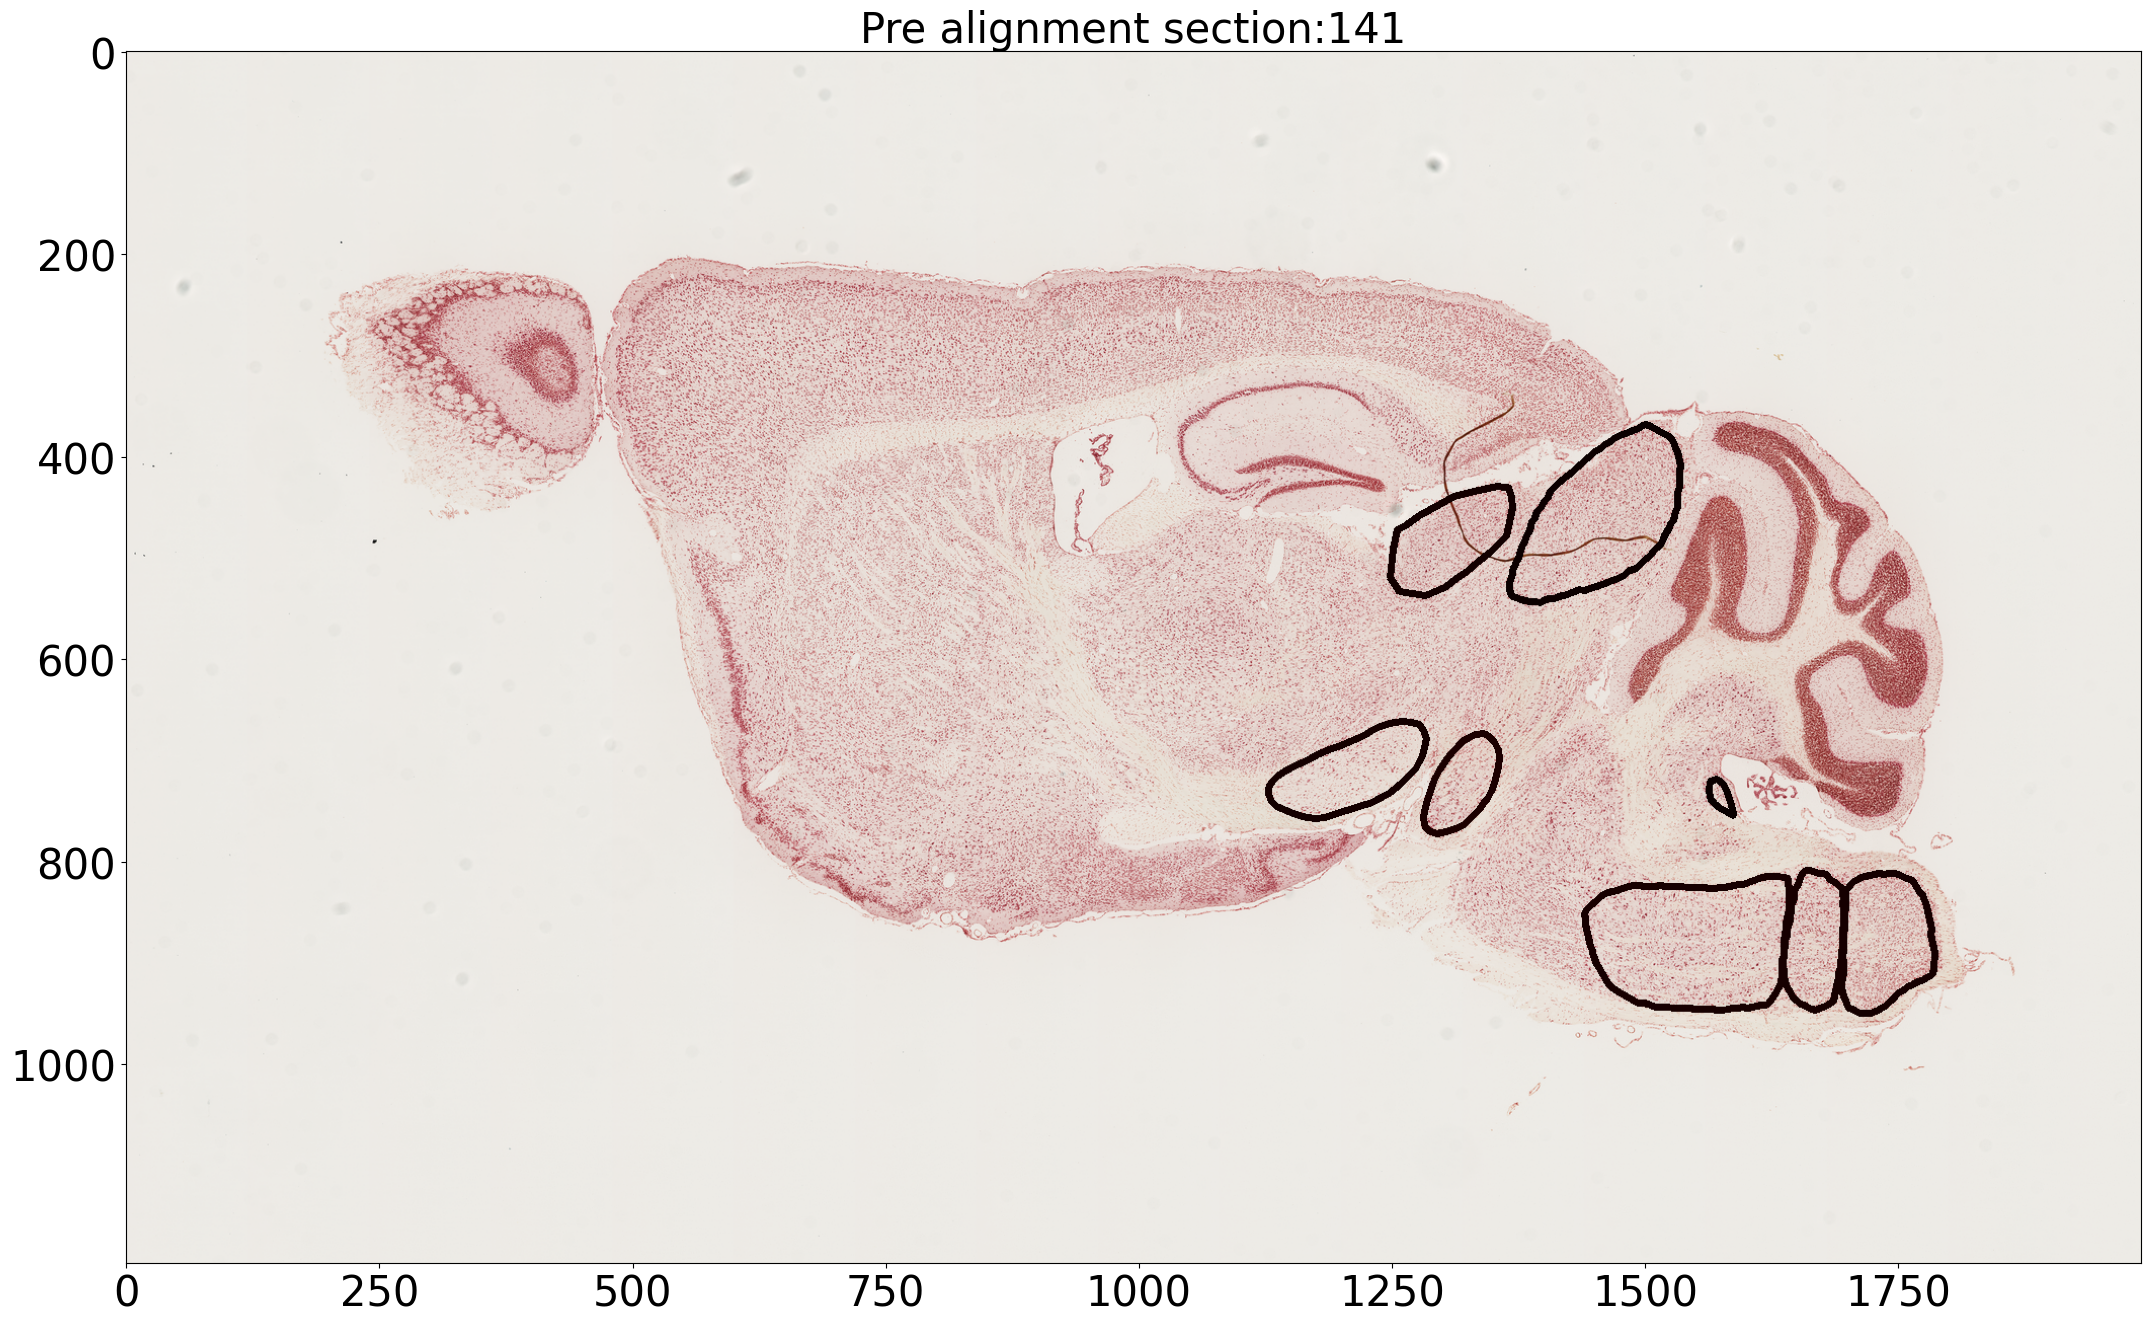

In [8]:
from matplotlib import pyplot as plt

PATH = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/MD589/preps/CH1'
DOWN16 = os.path.join(PATH, 'downsample_16')
ALIGNED = os.path.join(PATH, 'downsample_16_aligned')

section = 141
filepath = os.path.join(DOWN16, f'{section}.tif')
img = cv2.imread(filepath)

for structure in section_structure_polygons[section]:
    polygon = section_structure_polygons[section][structure][0]
    color = get_structure_number(structure)
    cv2.polylines(img, [polygon.astype(np.int32)], isClosed=True, color=color, thickness=5)
#     cv2.putText(img, structure, tuple(np.mean(polygon, axis=0).astype(int)), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 5, cv2.LINE_AA)

fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('Pre alignment section:{}'.format(section), fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()

## Fill up a pandas dataframe with the corrected vertices and save it.

In [10]:
data = []
files = sorted(os.listdir(DOWN16))
for file_name in files:
    section = int(file_name.split('.')[0])
    if section in section_structure_polygons:
        for structure in section_structure_polygons[section]:
            points = np.array(section_structure_polygons[section][structure][0]).astype(np.int32)
            data.append([structure, section, points])
            
df = pd.DataFrame(data=data, columns=['structure', 'section', 'vertices'])
outpath = os.path.join(f'{animal}_corrected_vertices.csv')
df.to_csv(outpath, index=False)
df.head()

,structure,section,vertices
0,DC,130,"[[1503, 703], [1499, 696], [1495, 690], [1495,..."
1,IC,130,"[[1342, 514], [1337, 514], [1331, 513], [1327,..."
2,PBG,130,"[[1252, 615], [1248, 605], [1254, 599], [1259,..."
3,SC,130,"[[1243, 489], [1238, 489], [1232, 489], [1227,..."
4,Sp5C,130,"[[1657, 812], [1663, 812], [1670, 811], [1678,..."
